In [ ]:
import numpy as np
import pandas as pd
import os
import warnings
import tensorflow as tf
from keras.models import load_model
from sklearn.model_selection import train_test_split
from keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate, merge, Dropout, BatchNormalization
from keras.models import Model
from keras.utils.vis_utils import plot_model
from IPython.display import SVG
warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
csvPath = "/content/drive/MyDrive/RecSys/FinalRatings.csv"
df = pd.read_csv(csvPath)
df = df.drop_duplicates(['user_id','name'],keep= 'last')
df= df.reset_index(drop=True)
print(df)
minHours = 50
# df['hours'] = df['hours'].str.replace(',', '.')
# df['hours'] = df['hours'].astype(float)
users_ratings = df.groupby('user_id').hours.agg(['sum']).reindex(df.user_id).reset_index()
# users_ratings = df.groupby('user_id').total.agg(['sum']).reindex(df.idx).reset_index()
# display(users_ratings)

### from model1
selected = users_ratings['sum'] > minHours

selected_users = df.loc[selected]

users = np.array(selected_users['user_id'])

unique, counts = np.unique(users, return_counts=True)
main_users =list()
for i, val in enumerate(unique):
    if counts[i] >= 10:
        main_users.append(val)

# display(selected_users[:10])
print(main_users)
df1 = pd.DataFrame()
for x in main_users:
  df1=df1.append(selected_users.loc[selected_users["user_id"] == x])

# selected_users = selected_users[]
                                                  

## from model 1
df1 = df1[['user_id', 'name', 'Rating M1']].copy()
df1.head()
df1.rename(columns = {df1.columns[2]:'rating1'}, inplace=True)
df1['game_id'] = df.groupby(['name']).ngroup()
dfTemp = df1.copy()
dfTemp['gamer_id'] = df.groupby(['user_id']).ngroup()
df1['gamer_id'] = df.groupby(['user_id']).ngroup()
# df1["gamer_id"] = df1["user_id"]
df1_toTrain = df1.copy().drop(columns={'name','user_id'})
# # df1_toTrain.rating1 = np.log10(df1_toTrain.rating1)
df1_toTrain.head(5)
# dfTemp.head(100)

         user_id                   name  ...  Rating M1 Rating M2
0      151603712              Fallout 4  ...          5         5
1       87445402              Fallout 4  ...          5         5
2       25096601              Fallout 4  ...          1         1
3      211925330              Fallout 4  ...          3         5
4      115396529              Fallout 4  ...          1         2
...          ...                    ...  ...        ...       ...
32626  154230723               Khet 2.0  ...          1         5
32627  116564064  SAMURAI WARRIORS 4-II  ...          1         5
32628  135400225           Life is Hard  ...          1         5
32629  135400225      Executive Assault  ...          1         5
32630  135400225          MirrorMoon EP  ...          1         5

[32631 rows x 21 columns]
[298950, 561758, 975449, 1612666, 1936551, 1950243, 2083767, 2110581, 2259650, 2643609, 2753525, 3449240, 3527485, 4824107, 5387470, 5990132, 6717871, 7431946, 7440594, 7907686, 825

,rating1,game_id,gamer_id
36,5,453,6
290,4,702,6
1101,1,701,6
1696,5,1211,6
3517,3,1325,6


In [ ]:
df1_toTrain.sort_values(by='gamer_id')



,rating1,game_id,gamer_id
36,5,453,6
24339,2,670,6
23944,3,1328,6
23654,3,933,6
23459,1,360,6
...,...,...,...
16472,5,1359,8568
2999,1,1211,8568
30415,1,521,8568
17484,3,1387,8568


In [ ]:
train, test = train_test_split(df1_toTrain, test_size=0.90, random_state=0)

In [ ]:
print(df1_toTrain.shape)

(17931, 3)


In [ ]:
n_items = int(dfTemp['game_id'].max())
n_users = int(dfTemp['gamer_id'].max())
print(n_items)
print(n_users)

1463
8568


In [ ]:
latent_dim = 20
# Define inputs
game_input = Input(shape=[1],name='game-input')
user_input = Input(shape=[1], name='user-input')
# MLP Embeddings
game_embedding_mlp = Embedding(n_items + 1, latent_dim, name='game-embedding-mlp')(game_input)
game_vec_mlp = Flatten(name='flatten-game-mlp')(game_embedding_mlp)
user_embedding_mlp = Embedding(n_users + 1, latent_dim, name='user-embedding-mlp')(user_input)
user_vec_mlp = Flatten(name='flatten-user-mlp')(user_embedding_mlp)
# MF Embeddings
game_embedding_mf = Embedding(n_items + 1, latent_dim, name='game-embedding-mf')(game_input)
game_vec_mf = Flatten(name='flatten-game-mf')(game_embedding_mf)
user_embedding_mf = Embedding(n_users + 1, latent_dim, name='user-embedding-mf')(user_input)
user_vec_mf = Flatten(name='flatten-user-mf')(user_embedding_mf)

concat = merge.concatenate([game_vec_mlp, user_vec_mlp], name='concat')
concat_dropout = Dropout(0.2)(concat)

fc_1 = Dense(100, name='fc-1', activation='relu')(concat_dropout)
fc_1_bn = BatchNormalization(name='batch-norm-1')(fc_1)
fc_1_dropout = Dropout(0.2)(fc_1_bn)
fc_2 = Dense(20, name='fc-2', activation='relu')(fc_1_dropout)
fc_2_bn = BatchNormalization(name='batch-norm-2')(fc_2)
fc_2_dropout = Dropout(0.2)(fc_2_bn)
# Prediction from both layers
pred_mlp = Dense(10, name='pred-mlp', activation='relu')(fc_2_dropout)
pred_mf = merge.dot(inputs=[game_vec_mf, user_vec_mf], axes = 1, name='pred-mf')
combine_mlp_mf = merge.concatenate([pred_mf, pred_mlp], name='combine-mlp-mf')
# Final prediction
result = Dense(1, name='result', activation='relu')(combine_mlp_mf)
model = Model([user_input, game_input], result)
opt =  tf.keras.optimizers.Adam(lr=0.0001)
model.compile(loss = 'mean_squared_error', optimizer=opt)


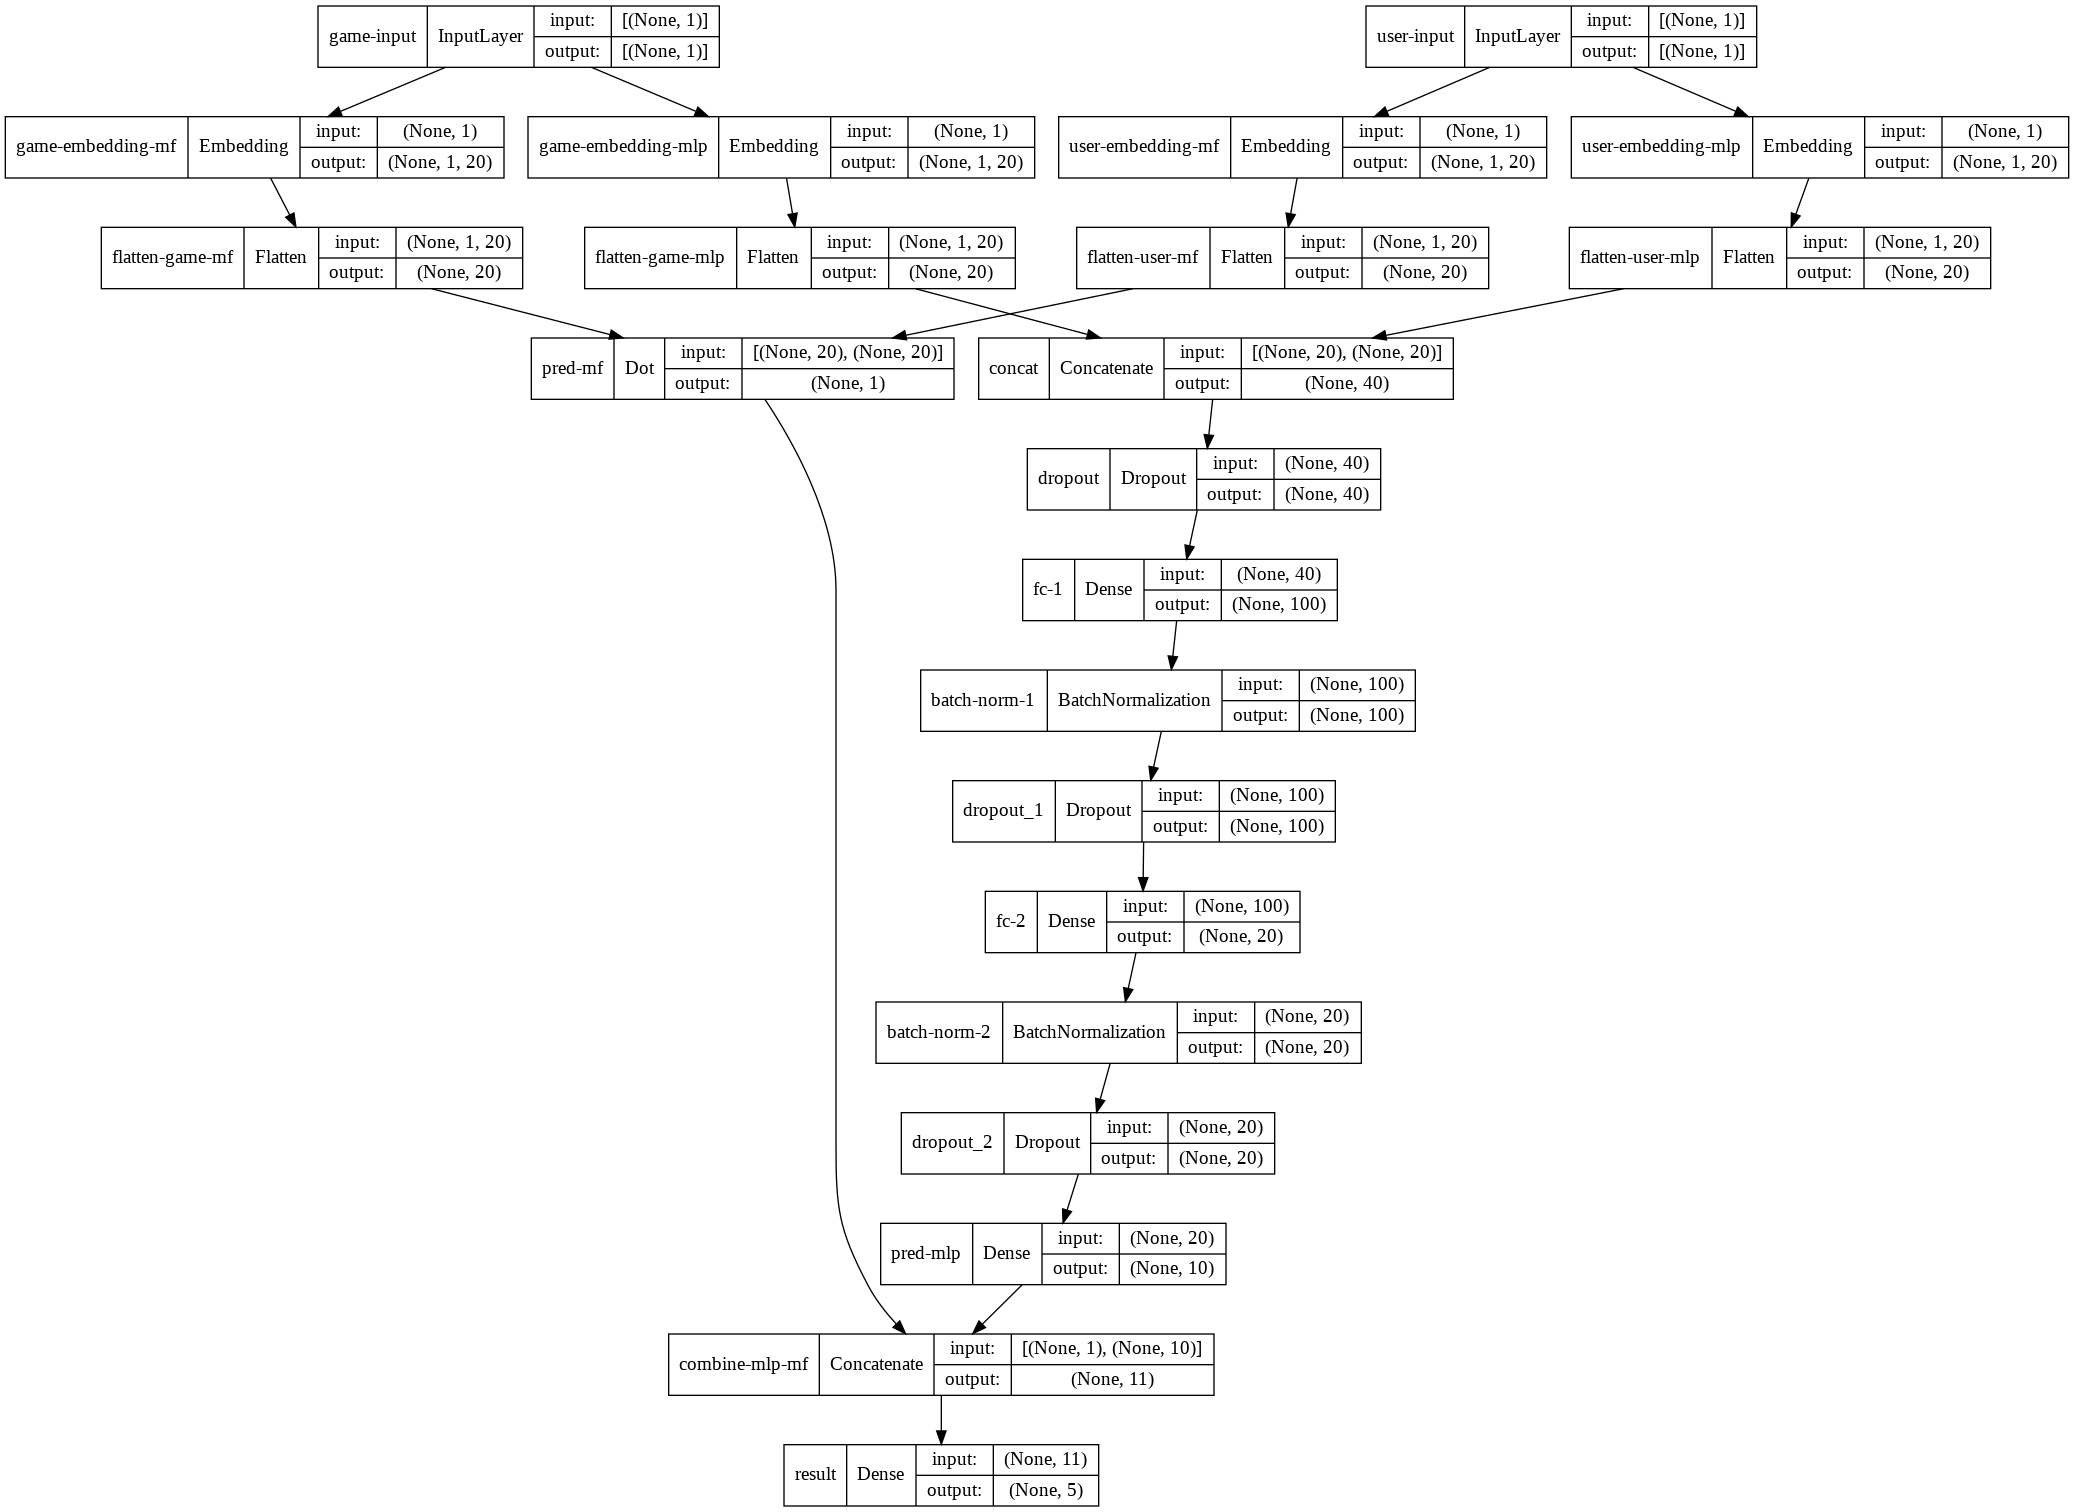

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
history = model.fit([train.gamer_id, train.game_id], train.rating1, epochs=100, verbose=1)

Epoch 1/100
55/55 [==============================] - 2s 9ms/step - loss: 7.9104
Epoch 2/100
55/55 [==============================] - 0s 9ms/step - loss: 7.5132
Epoch 3/100
55/55 [==============================] - 1s 9ms/step - loss: 7.3600
Epoch 4/100
55/55 [==============================] - 0s 9ms/step - loss: 7.0550
Epoch 5/100
55/55 [==============================] - 0s 9ms/step - loss: 6.6618
Epoch 6/100
55/55 [==============================] - 0s 9ms/step - loss: 6.2132
Epoch 7/100
55/55 [==============================] - 0s 9ms/step - loss: 5.9468
Epoch 8/100
55/55 [==============================] - 0s 8ms/step - loss: 5.6683
Epoch 9/100
55/55 [==============================] - 0s 9ms/step - loss: 5.4199
Epoch 10/100
55/55 [==============================] - 0s 9ms/step - loss: 5.1672
Epoch 11/100
55/55 [==============================] - 1s 10ms/step - loss: 4.7229
Epoch 12/100
55/55 [==============================] - 1s 9ms/step - loss: 4.4954
Epoch 13/100
55/55 [================

In [ ]:
predictions = model.predict([test.gamer_id.head(10), test.game_id.head(10)]) 
# print(predictions)
y_classes = predictions.argmax(axis=-1)
[print(predictions[i], test.rating1.iloc[i]) for i in range(0,10)]

[3.7897456] 4
[3.4964426] 5
[1.7087281] 1
[2.863424] 1
[2.431226] 2
[3.5293615] 2
[3.5970821] 1
[2.7780955] 5
[4.112491] 1
[2.9799583] 3


[None, None, None, None, None, None, None, None, None, None]

In [ ]:
results = model.evaluate([test.gamer_id, test.game_id], test.rating1)

495/495 [==============================] - 2s 3ms/step - loss: 3.2802


In [ ]:
# from matplotlib import pyplot as plt
# history = model.fit([train.gamer_id, train.game_id], train.rating1,validation_split = 0.3, epochs=100, batch_size=4)
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')
# plt.show()

In [ ]:
# from sklearn.metrics import mean_squared_error

# mean_squared_error(test.rating1[:10], predictions)

Group Recommendations

In [ ]:
## Selecting a random group of 5 people
import random
group1 = random.choices(main_users, k = 5)
print(group1)

[71331921, 131973876, 170172944, 164511211, 77830706]


In [ ]:
groupdf = pd.DataFrame()
tempdf = df1.copy().drop(columns={'user_id'})
for val in group1:
  groupdf = groupdf.append(tempdf.loc[df1["user_id"] == val])

display(groupdf)

,name,rating1,game_id,gamer_id
3452,Team Fortress 2,1,1211,1170
8814,Dota 2,5,363,1170
10938,Insurgency,3,634,1170
17541,War Thunder,1,1387,1170
19335,Heroes & Generals,1,590,1170
...,...,...,...,...
29778,Blockland,1,142,1294
30213,Medieval Engineers,1,758,1294
30263,Primal Carnage,5,904,1294
30534,Miscreated,1,773,1294


In [ ]:
groupR = groupdf[["gamer_id"]].values.ravel()
groupR = pd.unique(groupR)
print(groupR)

[1170 2933 4504 4243 1294]


In [ ]:
games = groupdf[["game_id"]].values.ravel()
games = pd.unique(games)
print(games)


unrated_groupdf =  df1[~df1.game_id.isin(games)]
unrated_games = unrated_groupdf[["game_id"]].values.ravel()
unrated_games = pd.unique(unrated_games)
group1dfPredict = pd.DataFrame(groupR)

unrateddfPredict = pd.DataFrame(unrated_games)
split = np.array_split(unrateddfPredict, int(len(unrateddfPredict)/5)+ (len(unrateddfPredict)%5))




[1211  363  634 1387  590 1392  804  379  738  390  539  161 1002   34
   82  233  360  248  516  312 1196 1218  935  328 1252  404  702  953
  988  835 1359 1175  264  476 1141  518 1245 1315  273 1349 1366  314
  477  611 1166 1220  453  538   12  386  658   81  907  737  842 1420
 1148  350 1109  665  599  142  758  904  773  144]


In [ ]:
groupMatrix = pd.DataFrame(index=groupR, columns=unrated_games )
for val in unrateddfPredict[0]:
    # print(val)
    # val = val.reset_index(drop = True)
    for p in groupR:
      # print(p)
      ppd = pd.DataFrame([p])
      valpd = pd.DataFrame([val])
      # print(p,val.loc[g].values.ravel())
      prediction = model.predict([ppd,valpd])
      # y_classes = prediction.argmax(axis=-1)+1
      # groupMatrix.at[p, val]  = y_classes[0]
      groupMatrix.at[p, val]  = prediction[0][0]
      # print('prediction Test')
      # print(y_classes)

In [ ]:

display(groupMatrix)


,701,1325,130,829,1355,456,892,1346,207,1087,1013,573,1291,560,993,807,352,606,891,1229,528,109,750,1080,1287,378,48,714,733,1329,323,47,549,1299,1292,1034,853,1184,534,1302,...,524,1403,1404,895,724,291,162,594,859,1354,849,1237,1425,155,997,1035,928,840,915,33,1114,289,743,626,1454,1301,1344,1003,763,138,582,954,1386,439,293,1152,254,191,92,521
1170,2.89015,4.18307,3.82384,3.67386,3.0988,3.42906,3.35046,2.45006,1.66471,3.70942,3.97104,3.61097,2.32987,2.98465,3.02616,2.79895,4.22702,3.22644,2.77806,3.62792,1.07743,2.68259,1.74128,1.27429,1.48381,1.87659,3.29426,2.29831,2.06535,3.93674,3.71364,1.78592,1.59466,3.70261,1.32932,1.28618,3.28299,2.27126,3.32494,3.02897,...,1.92014,1.91389,2.85866,3.37215,3.29916,3.18426,2.86667,2.34941,2.40439,1.86873,2.28494,2.51225,2.37188,3.17237,2.37901,2.42394,2.44289,1.26999,2.06453,2.08305,2.66874,2.88114,1.88581,2.41563,2.94085,3.11581,2.85874,2.49916,1.54616,2.7361,3.97228,2.48874,2.87546,2.7746,3.03838,2.0633,2.80673,1.71178,2.89343,3.00983
2933,2.93303,3.82362,3.63258,4.16101,3.63858,4.30423,4.08584,3.36126,1.64869,4.26295,4.90169,4.29185,1.43796,3.48241,1.13415,3.59044,3.78345,4.04627,2.22999,3.39596,1.89292,2.44703,1.20434,2.05832,0.218154,1.68684,1.88951,2.76015,1.92744,4.75636,3.33996,1.15619,0.892909,4.11749,1.06422,0.905073,3.95579,2.39701,2.28209,3.01905,...,1.90121,0.991067,2.05041,2.42781,4.37826,2.51722,2.17376,2.68854,2.88459,2.83403,3.88008,2.7507,2.55596,4.04626,2.11372,2.70832,2.61451,2.1503,1.67202,2.50704,3.53735,2.14289,3.13732,3.70522,4.22153,3.50453,2.59005,3.08774,1.98852,3.37221,4.57233,2.03062,2.6793,2.0289,3.2674,3.27133,3.09321,2.11394,2.49451,3.3292
4504,2.0551,2.18466,4.00233,2.97636,2.87007,4.02499,3.49372,3.14033,1.41455,4.4038,4.12825,3.91495,1.45938,3.35956,2.28446,2.36129,2.9988,4.06092,1.49006,1.61898,1.59074,2.03317,1.45601,2.47894,1.16455,2.00587,1.3132,2.07958,1.42719,4.49374,3.64005,1.30379,1.12747,4.06065,1.4132,1.27058,1.94236,2.1018,2.32256,2.15964,...,1.73801,1.17118,2.03676,2.71629,3.24763,3.0583,2.53903,2.38389,2.48681,2.80814,2.65389,3.21801,2.48015,2.22133,2.08682,1.3792,2.0301,2.50508,2.17217,1.82311,2.92838,1.44548,2.02623,3.35963,3.0272,2.62978,2.61179,2.34938,2.46582,3.56816,2.56596,2.21775,2.93219,1.79557,1.36349,3.16584,2.0235,1.64305,2.23966,1.66185
4243,2.60642,1.45548,3.67675,2.79645,2.98618,4.01198,3.72716,3.41843,1.64087,4.61507,4.26824,4.03552,1.5654,3.40419,2.09127,3.0499,2.74958,3.80278,1.69601,2.43966,1.93448,2.56024,1.95972,2.61226,0.88518,2.21956,1.54,2.09848,1.25204,4.39514,2.96505,1.33801,1.15504,4.01685,1.31392,1.375,1.89528,2.23933,2.39776,1.95313,...,2.00815,1.47938,1.81644,2.73933,3.26948,2.1531,2.28317,2.42743,1.90229,3.08705,3.11941,2.81924,2.76825,2.34351,2.02657,0.947251,1.73992,2.43455,2.08857,2.14184,2.82314,1.37388,2.08274,3.5141,3.24352,3.00029,2.35312,2.13887,2.43843,3.50906,3.26643,2.40227,2.77031,2.10296,1.35147,2.94233,1.95034,1.80405,1.84735,1.84737
1294,2.94534,4.68375,3.65963,2.3818,1.64562,2.94213,3.09623,0.715549,1.56255,3.50443,2.50494,3.02647,2.51312,1.84631,2.37945,2.46567,2.49342,3.09925,3.69063,2.69179,1.62505,2.85629,1.61934,0.855325,1.46526,2.8043,2.52129,2.36842,2.12757,3.33655,3.21773,2.13174,1.68421,2.76625,0.998436,1.8418,2.4335,1.58636,3.01996,3.12211,...,1.83636,1.87698,3.12649,3.25685,2.37782,3.57556,2.6625,2.95447,2.15685,1.85654,2.59627,2.30435,1.58605,1.96883,1.83527,3.5258,3.03322,0.95295,2.86237,2.12834,1.72425,3.37305,1.78552,1.84886,1.94008,1.96023,1.60617,2.68467,2.08492,1.70319,3.17243,2.13687,2.09064,2.57317,3.90346,1.5577,2.77063,1.46991,2.99882,3.70303


In [ ]:
aggf = ['Addition', 'Least_Misery', 'Most_Pleasure', 'Least_Misery+Most_Pleasure']
AggregationResult = pd.DataFrame(index = aggf, columns= unrated_games).fillna(0).astype(float)
for game in unrated_games:
  AggregationResult.at['Addition', game] = sum(groupMatrix[game])
  AggregationResult.at['Least_Misery', game] = min(groupMatrix[game])
  AggregationResult.at['Most_Pleasure', game] = max(groupMatrix[game])
  AggregationResult.at['Least_Misery+Most_Pleasure', game] = min(groupMatrix[game])+max(groupMatrix[game])
  

In [ ]:
display(AggregationResult)

,701,1325,130,829,1355,456,892,1346,207,1087,1013,573,1291,560,993,807,352,606,891,1229,528,109,750,1080,1287,378,48,714,733,1329,323,47,549,1299,1292,1034,853,1184,534,1302,...,524,1403,1404,895,724,291,162,594,859,1354,849,1237,1425,155,997,1035,928,840,915,33,1114,289,743,626,1454,1301,1344,1003,763,138,582,954,1386,439,293,1152,254,191,92,521
Addition,13.430037,16.330581,18.795130,15.989470,14.239242,18.712395,17.753409,13.085626,7.931365,20.495671,19.774167,18.879755,9.305725,15.077122,10.915492,14.266254,16.252271,18.235665,11.884757,13.774300,8.120615,12.579329,7.980685,9.279129,5.216950,10.593168,10.558259,11.604944,8.799608,20.918540,16.876430,7.715643,6.454287,18.663850,6.119089,6.678633,13.509927,10.595755,13.347316,13.282899,...,9.403875,7.432497,11.888756,14.512435,16.572359,14.488444,12.525138,12.803742,11.834929,12.454487,14.534587,13.604555,11.762294,13.752290,10.441387,10.984517,11.860633,9.312857,10.859664,10.683390,13.681846,11.216444,10.917616,14.843441,15.373181,14.210634,12.019869,12.759830,10.523849,14.888718,17.549431,11.276245,13.347886,11.275194,12.924199,13.000508,12.644414,8.742725,12.473765,13.551292
Least_Misery,2.055105,1.455476,3.632583,2.381799,1.645619,2.942134,3.096227,0.715549,1.414548,3.504431,2.504945,3.026466,1.437962,1.846313,1.134151,2.361294,2.493423,3.099247,1.490055,1.618979,1.077430,2.033175,1.204339,0.855325,0.218154,1.686838,1.313199,2.079581,1.252044,3.336552,2.965050,1.156189,0.892909,2.766251,0.998436,0.905073,1.895277,1.586361,2.282089,1.953131,...,1.738011,0.991067,1.816443,2.427811,2.377822,2.153095,2.173759,2.349412,1.902290,1.856539,2.284940,2.304348,1.586052,1.968826,1.835269,0.947251,1.739916,0.952950,1.672024,1.823114,1.724245,1.373880,1.785522,1.848860,1.940076,1.960227,1.606166,2.138874,1.546161,1.703195,2.565958,2.030622,2.090635,1.795567,1.351467,1.557704,1.950342,1.469914,1.847350,1.661855
Most_Pleasure,2.945341,4.683754,4.002326,4.161009,3.638581,4.304229,4.085838,3.418428,1.664711,4.615065,4.901692,4.291847,2.513116,3.482411,3.026155,3.590441,4.227022,4.060924,3.690633,3.627916,1.934482,2.856291,1.959722,2.612257,1.483806,2.804304,3.294263,2.760151,2.127575,4.756362,3.713642,2.131739,1.684207,4.117490,1.413199,1.841796,3.955794,2.397008,3.324939,3.122114,...,2.008149,1.913887,3.126489,3.372147,4.378259,3.575561,2.866673,2.954465,2.884592,3.087052,3.880075,3.218012,2.768250,4.046259,2.379008,3.525802,3.033217,2.505077,2.862370,2.507045,3.537348,3.373046,3.137316,3.705222,4.221528,3.504527,2.858743,3.087742,2.465822,3.568156,4.572332,2.488737,2.932190,2.774597,3.903461,3.271332,3.093210,2.113936,2.998815,3.703028
Least_Misery+Most_Pleasure,5.000445,6.139231,7.634909,6.542808,5.284200,7.246364,7.182065,4.133977,3.079259,8.119496,7.406637,7.318313,3.951078,5.328724,4.160307,5.951735,6.720445,7.160171,5.180689,5.246895,3.011912,4.889466,3.164060,3.467583,1.701960,4.491142,4.607462,4.839731,3.379619,8.092915,6.678692,3.287928,2.577116,6.883740,2.411635,2.746869,5.851071,3.983369,5.607028,5.075244,...,3.746160,2.904953,4.942933,5.799958,6.756082,5.728657,5.040431,5.303878,4.786882,4.943592,6.165016,5.522360,4.354302,6.015086,4.214278,4.473053,4.773133,3.458027,4.534394,4.330158,5.261593,4.746926,4.922839,5.554082,6.161604,5.464753,4.464909,5.226616,4.011983,5.271351,7.138291,4.519360,5.022825,4.570164,5.254928,4.829036,5.043552,3.583851,4.846166,5.364883


In [ ]:
AggregationResult.idxmax(axis=1)

Addition                       425
Least_Misery                   831
Most_Pleasure                  788
Least_Misery+Most_Pleasure    1182
dtype: int64

In [ ]:
AggregationResult = AggregationResult.sort_values(by ='Least_Misery+Most_Pleasure', axis=1, ascending=False)

In [ ]:
AggregationResult.sort_values(by ='Addition', axis=1, ascending=False)

,425,1182,831,1093,1290,137,507,1071,1329,751,461,1087,839,471,39,955,437,677,481,510,1347,61,99,1013,15,112,938,1246,1019,1401,870,173,419,1429,1309,630,1147,1063,1006,1424,...,968,818,427,1249,1165,614,1172,397,549,290,1320,30,681,1216,877,1292,1049,569,827,213,216,526,1296,227,600,1195,1134,780,676,364,1322,1308,1086,508,952,1287,501,520,478,686
Addition,22.560631,22.325711,22.008744,21.487277,21.254294,21.204688,21.006659,20.956816,20.918540,20.680876,20.623865,20.495671,20.485600,20.356186,20.354530,20.342239,20.316917,20.174319,20.085092,20.075182,20.065144,20.046973,19.898529,19.774167,19.758795,19.561374,19.500952,19.467261,19.286957,19.248881,19.246361,19.149139,19.138720,19.103409,19.100175,19.038751,19.027971,18.972137,18.951394,18.891196,...,6.620648,6.535967,6.535791,6.521801,6.517382,6.501891,6.483691,6.478953,6.454287,6.427595,6.273504,6.201023,6.177538,6.170571,6.160123,6.119089,6.086580,6.041431,5.997266,5.925422,5.884607,5.873969,5.809089,5.740851,5.680818,5.666527,5.659963,5.610497,5.587654,5.518217,5.507104,5.492450,5.442547,5.435354,5.237585,5.216950,5.072956,5.046415,4.958381,4.661035
Least_Misery,3.782262,3.668451,4.229971,3.717646,3.742850,3.716178,3.553087,3.476496,3.336552,3.527850,3.936497,3.504431,3.806388,3.256363,3.610352,3.570870,3.699988,3.142010,3.116076,3.572987,3.486558,3.546110,3.494251,2.504945,3.223607,3.287239,3.470229,3.082565,3.182203,3.035378,3.425991,2.666978,3.310771,2.884981,3.022481,3.130711,2.831613,3.462881,3.051508,2.807994,...,1.118878,0.957968,1.018624,0.455237,1.086689,0.884750,0.697864,0.887850,0.892909,0.712720,0.588703,0.829873,0.517923,1.024651,0.756273,0.998436,0.640500,0.947348,0.751119,0.472351,0.578247,0.790601,0.628828,0.858144,0.795701,0.817292,0.914174,0.446086,0.759009,0.615680,0.526252,0.598782,0.860095,0.644075,0.860693,0.218154,0.356856,0.736526,0.641371,0.606642
Most_Pleasure,5.186303,5.335379,4.581865,4.633583,4.636054,4.882934,4.729253,4.618917,4.756362,4.678414,4.459955,4.615065,4.330760,4.925761,4.576949,4.600985,4.707376,4.534233,4.787494,4.324108,4.359136,4.404641,4.320894,4.901692,4.752965,4.417707,4.367369,4.474221,4.579809,4.732827,4.693284,4.319779,4.212160,4.717563,4.522527,4.382604,4.367002,4.092139,4.354527,4.556535,...,1.662292,1.877052,1.601846,2.599003,1.683985,1.583763,1.936225,1.957623,1.684207,1.674950,2.079227,1.557629,1.752575,1.547379,1.829058,1.413199,1.757007,1.457317,1.395267,1.901532,1.522437,1.674452,1.344584,1.331546,1.305454,1.421496,1.379626,1.483941,1.475675,1.739172,1.722000,1.374161,1.425182,1.330418,1.304317,1.483806,1.458926,1.264938,1.287997,1.334306
Least_Misery+Most_Pleasure,8.968565,9.003830,8.811836,8.351229,8.378903,8.599113,8.282339,8.095413,8.092915,8.206264,8.396452,8.119496,8.137149,8.182123,8.187301,8.171854,8.407364,7.676242,7.903570,7.897095,7.845695,7.950751,7.815145,7.406637,7.976572,7.704946,7.837598,7.556786,7.762012,7.768205,8.119275,6.986757,7.522931,7.602543,7.545008,7.513315,7.198615,7.555020,7.406035,7.364530,...,2.781170,2.835020,2.620471,3.054240,2.770674,2.468513,2.634089,2.845473,2.577116,2.387670,2.667930,2.387502,2.270498,2.572030,2.585330,2.411635,2.397508,2.404665,2.146387,2.373884,2.100684,2.465053,1.973412,2.189690,2.101155,2.238788,2.293800,1.930028,2.234685,2.354853,2.248251,1.972942,2.285277,1.974493,2.165010,1.701960,1.815782,2.001464,1.929368,1.940948


In [ ]:
display(AggregationResult)

,1182,425,831,137,437,461,1290,1093,507,751,39,471,955,839,1087,870,1071,1329,15,61,481,510,1347,938,99,1401,1019,112,677,491,130,1429,286,1246,1063,1309,419,630,581,236,...,572,1172,1384,427,1228,877,549,570,1216,1461,614,526,1292,569,1049,290,30,1133,213,364,1134,1086,681,1322,1195,676,227,952,827,600,216,520,508,1296,1308,686,780,478,501,1287
Addition,22.325711,22.560631,22.008744,21.204688,20.316917,20.623865,21.254294,21.487277,21.006659,20.680876,20.354530,20.356186,20.342239,20.485600,20.495671,19.246361,20.956816,20.918540,19.758795,20.046973,20.085092,20.075182,20.065144,19.500952,19.898529,19.248881,19.286957,19.561374,20.174319,18.511470,18.795130,19.103409,17.719708,19.467261,18.972137,19.100175,19.138720,19.038751,18.634498,18.193994,...,6.892877,6.483691,6.639421,6.535791,6.865816,6.160123,6.454287,7.062880,6.170571,7.259299,6.501891,5.873969,6.119089,6.041431,6.086580,6.427595,6.201023,6.679745,5.925422,5.518217,5.659963,5.442547,6.177538,5.507104,5.666527,5.587654,5.740851,5.237585,5.997266,5.680818,5.884607,5.046415,5.435354,5.809089,5.492450,4.661035,5.610497,4.958381,5.072956,5.216950
Least_Misery,3.668451,3.782262,4.229971,3.716178,3.699988,3.936497,3.742850,3.717646,3.553087,3.527850,3.610352,3.256363,3.570870,3.806388,3.504431,3.425991,3.476496,3.336552,3.223607,3.546110,3.116076,3.572987,3.486558,3.470229,3.494251,3.035378,3.182203,3.287239,3.142010,3.465556,3.632583,2.884981,2.900770,3.082565,3.462881,3.022481,3.310771,3.130711,3.055343,3.307670,...,0.948476,0.697864,1.048702,1.018624,1.030937,0.756273,0.892909,0.909506,1.024651,0.709236,0.884750,0.790601,0.998436,0.947348,0.640500,0.712720,0.829873,0.761666,0.472351,0.615680,0.914174,0.860095,0.517923,0.526252,0.817292,0.759009,0.858144,0.860693,0.751119,0.795701,0.578247,0.736526,0.644075,0.628828,0.598782,0.606642,0.446086,0.641371,0.356856,0.218154
Most_Pleasure,5.335379,5.186303,4.581865,4.882934,4.707376,4.459955,4.636054,4.633583,4.729253,4.678414,4.576949,4.925761,4.600985,4.330760,4.615065,4.693284,4.618917,4.756362,4.752965,4.404641,4.787494,4.324108,4.359136,4.367369,4.320894,4.732827,4.579809,4.417707,4.534233,4.209763,4.002326,4.717563,4.698731,4.474221,4.092139,4.522527,4.212160,4.382604,4.442353,4.181126,...,1.715783,1.936225,1.583701,1.601846,1.587014,1.829058,1.684207,1.664181,1.547379,1.825641,1.583763,1.674452,1.413199,1.457317,1.757007,1.674950,1.557629,1.625807,1.901532,1.739172,1.379626,1.425182,1.752575,1.722000,1.421496,1.475675,1.331546,1.304317,1.395267,1.305454,1.522437,1.264938,1.330418,1.344584,1.374161,1.334306,1.483941,1.287997,1.458926,1.483806
Least_Misery+Most_Pleasure,9.003830,8.968565,8.811836,8.599113,8.407364,8.396452,8.378903,8.351229,8.282339,8.206264,8.187301,8.182123,8.171854,8.137149,8.119496,8.119275,8.095413,8.092915,7.976572,7.950751,7.903570,7.897095,7.845695,7.837598,7.815145,7.768205,7.762012,7.704946,7.676242,7.675319,7.634909,7.602543,7.599502,7.556786,7.555020,7.545008,7.522931,7.513315,7.497697,7.488795,...,2.664259,2.634089,2.632403,2.620471,2.617951,2.585330,2.577116,2.573686,2.572030,2.534877,2.468513,2.465053,2.411635,2.404665,2.397508,2.387670,2.387502,2.387474,2.373884,2.354853,2.293800,2.285277,2.270498,2.248251,2.238788,2.234685,2.189690,2.165010,2.146387,2.101155,2.100684,2.001464,1.974493,1.973412,1.972942,1.940948,1.930028,1.929368,1.815782,1.701960


In [ ]:
top5Games  = AggregationResult.columns[:5].values.ravel()
print(top5Games)

[1182  425  831  137  437]


In [ ]:
temp = df1[df1.game_id.isin(top5Games)]['name'].values.ravel()
TOP5 = pd.unique(temp)


THE FOLLOWING ARE THE TOP 5 GAMES

In [ ]:
print(TOP5)

['Ori and the Blind Forest' 'FEZ' 'Supreme Commander 2'
 'Europa Universalis IV' 'Blades of Time']


In [ ]:
new = groupMatrix[top5Games].copy()
new = new.set_axis(TOP5, axis=1)
display(new)

,Ori and the Blind Forest,FEZ,Supreme Commander 2,Europa Universalis IV,Blades of Time
1170,4.63504,3.78226,4.22997,4.88293,3.92744
2933,5.33538,5.1863,4.42814,4.85572,4.70738
4504,4.26391,4.80453,4.34724,3.8887,4.01102
4243,4.42293,4.92838,4.42152,3.86116,3.9711
1294,3.66845,3.85915,4.58186,3.71618,3.69999


In [ ]:
from expGenerator import ExpGenerator

exp = ExpGenerator()
exp.generateExp(new, privacy=False)

bruh
i wanted to surprise you guys
The majority of the group will love the game: Ori and the Blind Forest.
The majority of the group will love the game: FEZ.
The majority of the group will love the game: Supreme Commander 2.
The majority of the group will like Europa Universalis IV, some will love it!
The majority of the group will like Blades of Time, some will love it!
